# Generative simulations: spatiotemporal process models

*Space-Time Analytics — Lab for spatiotemporal process models*

2016-11-14

Your name: Martha Morrissey 

Date: 11/14/16

## Description

For this week's lab, you will be simulating from a variety of models of increasing complexity to better understand how spatiotemporal process models work. 

For each model below, simulate one realization of the parameters and the data (conditional on the parameters). Then, visualize the data in a way that makes sense given the spatial and temporal structure of the data. 

## Model 1: Model of the mean

*Specification*

We have observations $y_1, y_2, y_{N_t}$, each of which is independent and identically distributed as:

$$y_t \sim \text{Normal}(\mu = 0, \sigma_y)$$

$$\sigma_y \sim \text{Normal}_+(0, 1)$$

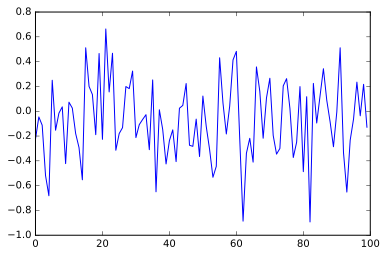

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import numpy 
import matplotlib.pyplot as plt

#define number of samples, create sigma, then pull a certain number of samples then plot 
#generate some value of the sigma y 

n =100
sigma_y = (abs(numpy.random.normal(loc=0.0, scale=1.0, size=1))) # using abs simulates half normal distrbution 


#print(sigma_y)
     
y = numpy.random.normal(0, sigma_y, n)


#print(y)
plt.plot(y)

plt.show()

## Model 2: Varying-intercept model

*Specification*

At $N_s = 100$ spatial locations we observe the response $y(s, t)$ at each of $N_t = 10$ time steps:

**Likelihood**

$$y(s, t) \sim \text{Normal}(\beta_t, \sigma_y)$$

**Priors**

$$\beta_t \sim \text{Normal}(0, \sigma_\beta)$$

$$\sigma_\beta \sim \text{Normal}_+(0, 1)$$

$$\sigma_y \sim \text{Normal}_+(0, 1)$$

In [5]:
Ns = 100
Nt = 10

# draw priors

sigma_y = (abs(numpy.random.normal(loc=0.0, scale=1.0, size=1)))
sigma_beta = (abs(numpy.random.normal(loc = 0.0, scale = 1.0, size = 1)))
beta = numpy.random.normal(0, sigma_y, Nt)



# draw observations from the likelihood
a = numpy.zeros(shape=(Ns, Nt))


In [6]:
#switching to R. Confused about filling a matrix in python. 

%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [7]:
%%R
N_s <- 100 # number of sites
N_t <- 10 # number of time steps

# draw priors
sigma_y <- abs(rnorm(n = 1, mean = 0, sd = 1))
sigma_beta <- abs(rnorm(n = 1, mean = 0, sd = 1))
beta <- rnorm(n = N_t, mean = 0, sd = sigma_beta)

# draw observations from the likelihood
y <- matrix(nrow = N_s, ncol = N_t)
for (t in 1:N_t) { 
    y[, t] <- rnorm(N_s, mean = beta[t], sd = sigma_y)
}

In [8]:
from rpy2.robjects.packages import importr
reshape2 = importr('reshape2')
ggplot2 = importr('ggplot2')

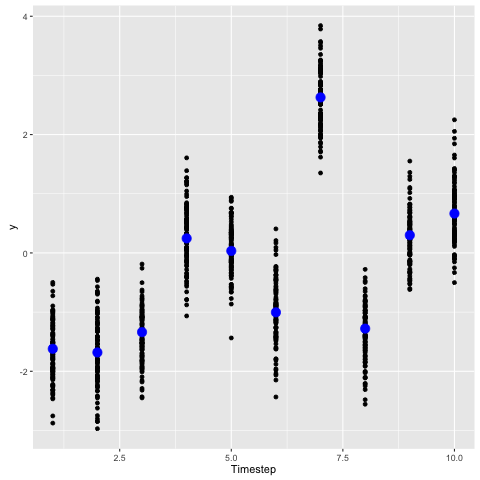

In [10]:
%%R
y_df <- melt(y, varnames = c("Site", "Timestep"))

ggplot(y_df, aes(x = Timestep, y = value)) + 
    geom_point() + 
    ylab("y") + 
    geom_point(data = data.frame(Timestep = 1:N_t, value = beta), 
               col = "blue", size = 4)

#beta Ts shown in blue for each time step. 

## Model 3: AR(1) model

*Specification*

At $N_s = 100$ spatial locations we observe the response $y(s, t)$ at each of $N_t = 10$ time steps:

**Likelihood**

$$y(s, t) \sim \text{Normal}(\beta_t, \sigma_y)$$

**Priors**

$$\beta_t = \beta_{t - 1} + \eta_t$$

$$\eta_t \sim \text{Normal}(0, \sigma_\eta)$$

$$\beta_{t = 0} \sim \text{Normal}(0, 1)$$

$$\sigma_\eta \sim \text{Normal}_+(0, 1)$$

$$\sigma_y \sim \text{Normal}_+(0, 1)$$

In [11]:
%%R
# initialize empty objects
y <- matrix(nrow = N_s, ncol = N_t)
beta <- rep(NA, N_t)

# draw from priors
sigma_eta <- abs(rnorm(n = 1, mean = 0, sd = 1))
eta <- rnorm(n = N_t, mean = 0, sd = sigma_eta)

beta_0 <- rnorm(n = 1, mean = 0, sd = 1)
for (t in 1:N_t) {
    if (t == 1) {
        beta[t] <- beta_0 + eta[t]
    } else {
        beta[t] <- beta[t - 1] + eta[t]
    }
}

# simulate observations
for (i in 1:N_s) {
    for (t in 1:N_t) {
        y[i, t] <- rnorm(n = 1, mean = beta[t], sd = sigma_y)
    }
}

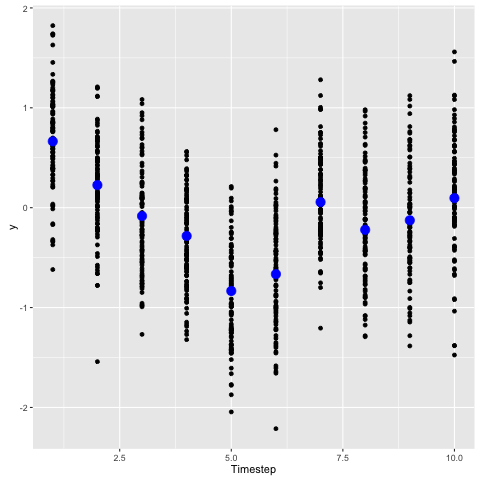

In [12]:
%%R
y_df <- melt(y, varnames = c("Site", "Timestep"))

ggplot(y_df, aes(x = Timestep, y = value)) + 
    geom_point() + 
    ylab("y") + 
    geom_point(data = data.frame(Timestep = 1:N_t, value = beta), 
               col = "blue", size = 4)

# 1 realization= observations at 100 locations and 10 timesteps. can see temporal autocorrelation. Right now only temporal 
#dependence 
#AR1 - only go back one time step to figure out dependence (first order Markov)

## Model 4: AR(1) model + spatially-varying intercept


At $N_s = 100$ spatial locations with locations $x_1, x_2, ..., x_{N_s}$ we observe the response $y(s, t)$ at each of $N_t = 10$ time steps:

**Likelihood**

$$y(s, t) \sim \text{Normal}(\alpha_s + \beta_t, \sigma_y)$$

**Priors**

$$\alpha_s \sim \text{GP}(0, [\gamma^2 \text{exp}(-\phi d_{ij})])$$

$$\beta_t = \beta_{t - 1} + \eta_t$$

$$\eta_t \sim \text{Normal}(0, \sigma_\eta)$$

$$\beta_{t = 0} \sim \text{Normal}(0, 1)$$

$$\sigma_\eta \sim \text{Normal}_+(0, 1)$$

$$\sigma_y \sim \text{Normal}_+(0, 1)$$

$$\gamma \sim \text{Normal}_+(0, 1)$$

$$\phi \sim \text{Normal}_+(0, 1)$$


In [32]:
from rpy2.robjects.packages import importr

MASS = importr('MASS')
viridis = importr('viridis')
ggplot = importr('ggplot2')

In [18]:
%%R
# set up data
N_s <- 100
N_t <- 10
x <- matrix(runif(N_s * 2), ncol = 2)
D <- as.matrix(dist(x))
y <- matrix(nrow = N_s, ncol = N_t)

# draw parameters
omega <- abs(rnorm(1))
phi <- abs(rnorm(1))
gamma <- abs(rnorm(1))
sigma_y <- abs(rnorm(1))
sigma_eta <- abs(rnorm(1))
beta_0 <- rnorm(1)

# temporal effects
beta <- rep(NA, N_t)
eta <- rnorm(n = N_t, mean = 0, sd = sigma_eta)
beta[1] <- beta_0 + eta[1]
for (t in 2:N_t) {
    beta[t] <- beta[t - 1] + eta[t]
}

# spatial effects
K <- gamma**2 * exp(-phi * D)
alpha <- mvrnorm(n = 1, mu = rep(0, N_s), Sigma = K)

# observations
for (i in 1:N_s) {
    for (t in 1:N_t) {
        y[i, t] <- rnorm(1, mean = alpha[i] + beta[t], sigma_y)
    }
}

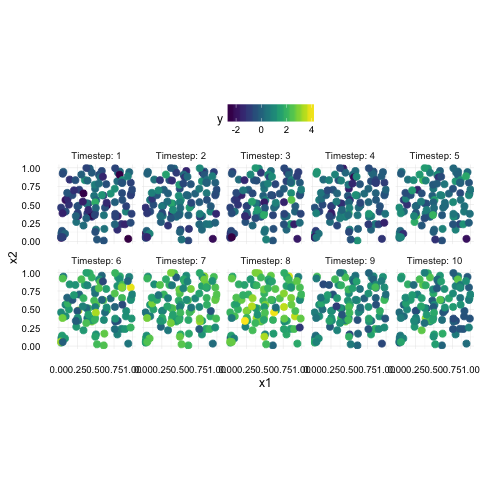

In [27]:
%%R
y_df <- melt(y, varnames = c("Site", "Timestep"), value.name = "y")
y_df$x1 <- x[y_df$Site, 1]
y_df$x2 <- x[y_df$Site, 2]

ggplot(y_df, aes(x = x1, y = x2, color = y)) + 
    geom_point(size = 3) + 
    facet_wrap(~ Timestep, nrow = 2, labeller = "label_both") + 
    scale_color_viridis() + 
    theme_minimal() + 
    coord_equal() + 
    theme(legend.position = "top")

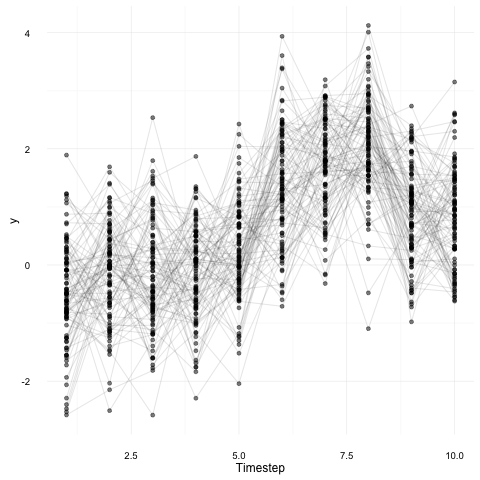

In [34]:
%%R
ggplot(y_df, aes(x = Timestep, y = y, group = Site)) + geom_line(alpha = .1) +  geom_point(alpha = .5) + theme_minimal()

## Model 5: Spatiotemporal process model

At $N_s = 100$ spatial locations with locations $x_1, x_2, ..., x_{N_s}$ we observe the response $y(s, t)$ at each of $N_t = 10$ time steps:

**Likelihood**

$$y(s, t) \sim \text{Normal}(\alpha_{st}+ \beta_{t}, \sigma_y)$$

**Priors**

$$\alpha_{st} = \alpha_{s, t - 1} + \omega_{st}$$

$$\omega_{s, t} \sim \text{GP}(0, [\gamma^2 \text{exp}(-\phi d_{ij})])$$

$$\alpha_{s, t = 0} \sim \text{GP}(0, [\gamma^2 \text{exp}(-\phi d_{ij})])$$

$$\beta_t = \beta_{t - 1} + \eta_t$$

$$\eta_t \sim \text{Normal}(0, \sigma_\eta)$$

$$\beta_{t = 0} \sim \text{Normal}(0, 1)$$

$$\sigma_\eta \sim \text{Normal}_+(0, 1)$$

$$\sigma_y \sim \text{Normal}_+(0, 1)$$

$$\gamma \sim \text{Normal}_+(0, 1)$$

$$\phi \sim \text{Normal}_+(0, 1)$$

In [36]:
%%R
# set up data
N_s <- 100
N_t <- 10
x <- matrix(runif(N_s * 2), ncol = 2)
D <- as.matrix(dist(x))
y <- matrix(nrow = N_s, ncol = N_t)

# draw parameters
phi <- abs(rnorm(1))
gamma <- abs(rnorm(1))
sigma_y <- abs(rnorm(1))

sigma_eta <- abs(rnorm(1))
eta <- rnorm(N_t, 0, sigma_eta)

# temporal effects
beta_0 <- rnorm(1)
beta <- rep(NA, N_t)
beta[1] <- beta_0 + eta[1]
for (t in 2:N_t) {
    beta[t] <- beta[t - 1] + eta[t]
}

# spatiotemporal effects
K <- gamma**2 * exp(-phi * D)
alpha_0 <- mvrnorm(n = 1, mu = rep(0, N_s), Sigma = K)
omega <- matrix(nrow = N_s, ncol = N_t)
alpha <- matrix(nrow = N_s, ncol = N_t)
for (t in 1:N_t) {
    omega[, t] <- mvrnorm(n = 1, mu = rep(0, N_s), Sigma = K)
    if (t == 1) {
        alpha[, t] <- alpha_0 + omega[, 1]
    } else {
        alpha[, t] <- alpha[, t - 1] + omega[, t]
    }
}

# observations
for (i in 1:N_s) {
    for (t in 1:N_t) {
        y[i, t] <- rnorm(1, mean = alpha[i, t] + beta[t], sd = sigma_y)
    }
}

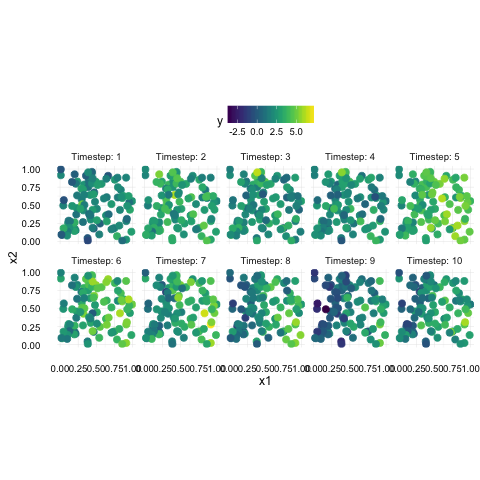

In [38]:
%%R
# make a data frame for y and add the spatial coordinates
y_df <- melt(y, varnames = c("Site", "Timestep"), value.name = "y")
y_df$x1 <- x[y_df$Site, 1]
y_df$x2 <- x[y_df$Site, 2]

ggplot(y_df, aes(x = x1, y = x2, color = y)) + 
    geom_point(size = 3) + 
    facet_wrap(~ Timestep, nrow = 2, labeller = "label_both") + 
    scale_color_viridis() + 
    theme_minimal() + 
    coord_equal() + 
    theme(legend.position = "top")

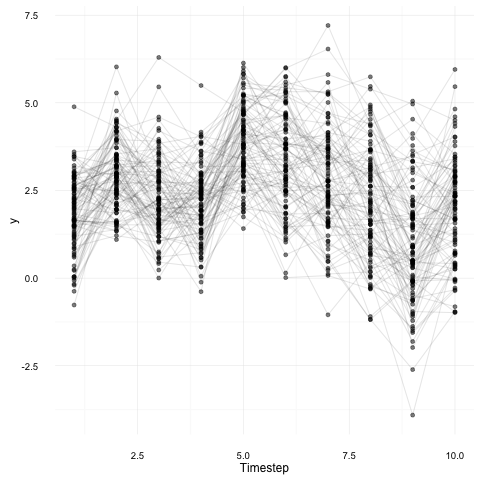

In [39]:
%%R
ggplot(y_df, aes(x = Timestep, y = y, group = Site)) + 
    geom_line(alpha = .1) + 
    geom_point(alpha = .5) + 
    theme_minimal()

## Check your understanding

Explain how you would modify your spatiotemporal process model to accomplish the following (e.g., which parameters would you change, and how would you change them?): 

### Reduce spatial variation

increase N_s

### Increase the differences among years in the response $y$

currently the differences among years in the response is 1 because the code in the observation section goes for (t in 1:N_t). To change to every other year or every three years that code could be modified to (t in 1:N_t + 2) or (t in 1:N_t + 3). 

### Increase the spatial range for the spatiotemporal effect, so that distant sites behave more similarly

increaase the values of K